In [1]:
import pandas as pd
import os
#from Preprocessing.params import *


def get_data(LOCAL_FILEPATH):
    data = pd.read_csv(LOCAL_FILEPATH)
    print(f"data acquired with shape {data.shape}")
    return data



#This is the first 2 days worth of data where general_runs stats are all skewed
def remove_221_rows(data):
    data = data[221:]
    print(f"first 221 rows removed. New shape = {data.shape}")
    return data

## Dropping rows if we have no betting data, and imputing if we have some betting data
def dropping_no_betting_data(data):
    data = data.dropna(subset=['f_bsp', 'f_pm_15m', 'f_pm_10m', 'f_pm_05m' , 'f_pm_03m', 'f_pm_02m', 'f_pm_01m'], how='all')
    def impute_row(row):
        row = row.fillna(method='ffill').fillna(method='bfill')
        return row
    columns_to_impute = ['f_bsp', 'f_pm_15m', 'f_pm_10m', 'f_pm_05m', 'f_pm_03m', 'f_pm_02m', 'f_pm_01m']
    data[columns_to_impute] = data[columns_to_impute].apply(impute_row, axis=1)

    #deleting row that has 0s for all odds for some reason


    print(f"Cleaned up missing odds. New shape = {data.shape}")
    return data

def josh_features(data):

    #Creating country feature
    irish_tracks = [
    "SLIGO", "LIMERICK", "NAVAN", "WEXFORD", "CURRAGH",
    "GALWAY", "KILBEGGAN", "GOWRAN PARK", "BELLEWSTOWN",
    "LISTOWEL", "THURLES", "BALLINROBE", "TRAMORE",
    "LEOPARDSTOWN", "DOWN ROYAL", "ROSCOMMON", "CORK",
    "DUNDALK", "KILLARNEY", "LAYTOWN", "TIPPERARY",
    "FAIRYHOUSE", "NAAS", "DOWNPATRICK", "CLONMEL",
    "PUNCHESTOWN"
]

    data['country'] = data['f_track'].apply(lambda x: 'IRE' if x in irish_tracks else 'GB')

    #Completing f_class for Irish races

    # Calculate mean ratings for each 'f_id' group
    mean_ratings_by_id = data.groupby('f_id')['f_rating_or'].mean()

    # Define the mapping of mean ratings to f_class values
    rating_to_f_class_mapping = {
        (96, float('inf')): 1,
        (86, 96): 2,
        (76, 86): 3,
        (66, 76): 4,
        (56, 66): 5,
        (46, 56): 6,
        (-float('inf'), 46): 7
    }

    # Function to map mean ratings to f_class values
    def map_rating_to_f_class(mean_rating):
        for rating_range, f_class_value in rating_to_f_class_mapping.items():
            if rating_range[0] <= mean_rating <= rating_range[1]:
                return f_class_value

    # Apply the mapping to fill NULL values in 'f_class' column based on mean ratings
    data['f_class'] = data.apply(lambda row: map_rating_to_f_class(mean_ratings_by_id.get(row['f_id'])), axis=1)

    # Now the 'f_class' column should be filled based on the specified mapping using mean ratings

    # Merge the mean ratings back into the original DataFrame based on 'f_id'
    data = data.merge(mean_ratings_by_id, how='left', left_on='f_id', right_index=True)

    # Rename the merged mean rating column for clarity
    data.rename(columns={'f_rating_or_y': 'mean_f_rating_or_race', 'f_rating_or_x' : 'f_rating_or' }, inplace=True)

    # Create official rating vs average rating in the race feature
    data['or_rating_vs_avg_race'] = data['f_rating_or'] - data['mean_f_rating_or_race']

    # Create odds percentage and movement features
    data['15m_odds_prob'] = 1 / data['f_pm_15m']
    data['5m_odds_prob'] = 1 / data['f_pm_05m']
    data['15to5m_odds_move_perc'] = (data['5m_odds_prob'] / data['15m_odds_prob'] - 1)
    data['15to5m_odds_move_raw'] = (data['5m_odds_prob'] - data['15m_odds_prob'])
    print(f"Added Josh features. New shape = {data.shape}")
    return data

def class_or_rating_average(data):
    average_or_rating_class = data.groupby("f_class")['f_rating_or'].mean().reset_index()
    average_or_rating_class.rename(columns={'f_rating_or': 'average_or_rating_class'}, inplace=True)
    data = data.merge(average_or_rating_class, on='f_class')
    data['above_below_official_rating_class'] = data['f_rating_or']- data['average_or_rating_class']
    print(f"Added Oli features 2/4. New shape = {data.shape}")
    return data


def oli_features(data):
    data = data.sort_values(by='f_ko')
    data['PreviousPosition'] = data.groupby('f_horse')['f_place'].shift(fill_value=0)

    data = data.sort_values(by=['f_id', 'pred_isp'])
    data['PredictedRank'] = data.groupby('f_id').cumcount() + 1
    print(f"Added Oli features 4/4. New shape = {data.shape}")
    return data

In [2]:
data = get_data("../raw_data/raw_data_v2.2.csv")
data = remove_221_rows(data)
data = dropping_no_betting_data(data)
    #Dropping line that has 0 for all odds
data = data[data.id != 16157910000382]
data = josh_features(data)
data = class_or_rating_average(data)
data = oli_features(data)

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/1371766039.py:7: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(LOCAL_FILEPATH)


data acquired with shape (118575, 116)
first 221 rows removed. New shape = (118354, 116)


/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/1371766039.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_impute] = data[columns_to_impute].apply(impute_row, axis=1)


Cleaned up missing odds. New shape = (118093, 116)
Added Josh features. New shape = (118092, 123)
Added Oli features 2/4. New shape = (118092, 125)
Added Oli features 4/4. New shape = (118092, 127)


In [3]:
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

def preprocess_features_v2(data: pd.DataFrame) -> np.ndarray:
    #--------------------------------------------------------------------------#
    print('number of columns: ', len(data.columns))
    ### DROP IRRELEVANT COLUMNS ###
    redundant_columns = [#"id",
                         #"f_id",
                         "f_racetype",
                         #"f_horse",
                         "f_jockey",
                         "f_trainer",
                         "f_rating_hc",
                         "f_lto_pos",
                         "f_bsp",
                         "f_pm_15m",
                         "f_pm_10m",
                         "f_pm_05m",
                         "f_pm_03m",
                         "f_pm_02m",
                         #"f_pm_01m",
                         "f_bsp_p_back",
                         "f_bsp_p_lay",
                         #"f_pm_01m_p_back",
                         "f_pm_01m_p_lay",
                         "f_pm_15m_p_back",
                         "f_pm_15m_p_lay",
                         "general_runs_win_at",
                         "general_runs_win_l200r",
                         "general_runs_win_l50r",
                         "general_runs_win_l16r",
                         "general_runs_at",
                         "general_runs_l200r",
                         "general_runs_l50r",
                         "general_runs_l16r",
                         "sum_bsp_trainer_at",
                         "sum_bsp_jockey_at",
                         "sum_bsp_horse_at",
                         "sum_bsp_trainer_l16r",
                         "sum_bsp_jockey_l16r",
                         "sum_bsp_trainer_l50r",
                         "sum_bsp_jockey_l50r",
                         "sum_bsp_trainer_l200r",
                         "sum_bsp_jockey_l200r",
                         "sum_bsp_horse_l10r",
                         "sum_bsp_horse_l5r",
                         "sum_bsp_horse_l2r",
                         "15to5m_odds_move_perc",
                         "15to5m_odds_move_raw",
                         "15m_odds_prob",
                         "5m_odds_prob"]
    data.drop(columns = redundant_columns, inplace = True)
    print("✅ DROPPED IRRELEVANT COLUMNS")

    #--------------------------------------------------------------------------#

    ### DROP ROWS WITH NULL VALUES IN THESE COLUMNS ###
    data.dropna(axis = 0, inplace = True,
                subset = ["f_pace",
                          "f_stall",
                          "stall_position",
                          "f_going",
                          "f_rating_or",
                          "or_rating_vs_avg_race",
                          "country",
                          "mean_f_rating_or_race",
                          "f_class",
                          "average_or_rating_class",
                          "above_below_official_rating_class",
                          "PreviousPosition",
                          "PredictedRank",
                          ])
    print("✅ DROPPED ROWS WITH NULL VALUES")

    #--------------------------------------------------------------------------#

    ### STRIP SURROUNDING WHITESPACE ###
    data['f_track'] = data['f_track'].str.strip()
    print("✅ WHITESPACE STRIPPED FROM 'f_track'")

    #--------------------------------------------------------------------------#

    ### CONVERT ODDS TO PROBABILITY ###
    def odds_to_prob(x):
        return 1/x
    data['pred_isp'] = data['pred_isp'].apply(odds_to_prob)
    print("✅ ODDS CONVERTED TO PROBABILITY (1/ODDS)")

    #--------------------------------------------------------------------------#

    ### CODE WINNERS AS '1', REST AS '0' ###
    def winner(x):
        if x == 1:
            return 1
        else:
            return 0
    data['f_place'] = data['f_place'].apply(winner)
    print("✅ WINNERS CODED AS '1', REST '0'")

    #--------------------------------------------------------------------------#

    ### 'f_ko' CONVERTED TO DATETIME ###
    data['f_ko'] = data['f_ko'].astype('datetime64[ns]')
    print("✅ 'f_ko' CONVERTED TO DATETIME")

    #--------------------------------------------------------------------------#

    ### ENCODE THE GOING (GROUND CONDITION) ###
    def f_going_coder(x):
        if x == 'FRM':
            return 1
        elif x == 'GTF':
            return 2
        elif x == 'GD' or x == 'GTY' or x == 'STD':
            return 3
        elif x == 'YLD' or x == 'YTS' or x == 'STSL' or x == 'GTS':
            return 4
        elif x == 'SFT':
            return 5
        elif x == 'HVY' or x == 'HTS':
            return 6
    data['f_going'] = data['f_going'].apply(f_going_coder)
    print("✅ TRACK CONDITIONS ORDINALLY ENCODED")

    #--------------------------------------------------------------------------#

    ### MINMAX SCALE NUMERIC FEATURES ###
    set_config(transform_output = "pandas")
    numeric_features = ["f_going",
                        "average_or_rating_class",
                        "above_below_official_rating_class",
                        "PreviousPosition",
                        "PredictedRank",
                        "f_distance",
                        "f_class",
                        "f_age",
                        "f_pace",
                        "f_weight",
                        "f_runners",
                        "f_rating_or",
                        "mean_f_rating_or_race",
                        "or_rating_vs_avg_race",
                        "f_rating_rbd",
                        "f_stall",
                        "stall_position",
                        "trainer_runs_win_at",
                        "trainer_runs_win_l200r",
                        "trainer_runs_win_l50r",
                        "trainer_runs_win_l16r",
                        "trainer_runs_at",
                        "trainer_runs_l200r",
                        "trainer_runs_l50r",
                        "trainer_runs_l16r",
                        "jockey_runs_win_at",
                        "jockey_runs_win_l200r",
                        "jockey_runs_win_l50r",
                        "jockey_runs_win_l16r",
                        "jockey_runs_at",
                        "jockey_runs_l200r",
                        "jockey_runs_l50r",
                        "jockey_runs_l16r",
                        "horse_runs_win_at",
                        "horse_runs_win_l10r",
                        "horse_runs_win_l5r",
                        "horse_runs_win_l2r",
                        "horse_runs_at",
                        "horse_runs_l10r",
                        "horse_runs_l5r",
                        "horse_runs_l2r",
                        "iv_horse_at",
                        "iv_trainer_l200r",
                        "iv_trainer_l50r",
                        "iv_trainer_l16r",
                        "iv_trainer_at",
                        "iv_jockey_l200r",
                        "iv_jockey_l50r",
                        "iv_jockey_l16r",
                        "iv_jockey_at",
                        "ae_horse_l10r",
                        "ae_horse_l5r",
                        "ae_horse_l2r",
                        "ae_horse_at",
                        "ae_trainer_l200r",
                        "ae_trainer_l50r",
                        "ae_trainer_l16r",
                        "ae_trainer_at",
                        "ae_jockey_l200r",
                        "ae_jockey_l50r",
                        "ae_jockey_l16r",
                        "ae_jockey_at",
                        "rolling_avg_trainer_finish_at",
                        "rolling_avg_trainer_finish_l200r",
                        "rolling_avg_trainer_finish_l50r",
                        "rolling_avg_trainer_finish_l16r",
                        "rolling_avg_horse_finish_at",
                        "rolling_avg_horse_finish_l10r",
                        "rolling_avg_horse_finish_l5r",
                        "rolling_avg_horse_finish_l2r",
                        "rolling_avg_jockey_finish_at",
                        "rolling_avg_jockey_finish_l200r",
                        "rolling_avg_jockey_finish_l50r",
                        "rolling_avg_jockey_finish_l16r",
                        ]
    numeric_transformer = Pipeline(
        steps=[("scaler", MinMaxScaler())])
    print("✅ NUMERIC FEATURES MINMAX-SCALED")

    #--------------------------------------------------------------------------#

    ### IMPUTE HEADGEAR NULLS WITH 'no_headgear' ###
    headgear_feature = ["f_headgear"]
    headgear_imputer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy = 'constant',
                                         fill_value = 'no_headgear'))])
    print("✅ IMPUTED 'no_headgear' for NULLS IN 'f_headgear'")

    #--------------------------------------------------------------------------#

    ### MEAN IMPUTE CERTAIN FEATURES ###
    mean_impute_features = ["f_dob", "f_prb_avg"]
    mean_imputer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy = 'mean'))])
    print("✅ IMPUTED MEAN FOR NULLS IN 'f_dob' & 'f_prb_avg'")

    #--------------------------------------------------------------------------#

    ### IMPUTE NULLS WITH 0's ###
    zero_impute_features = ["f_rating_rbd",
                            "trainer_runs_win_at",
                            "trainer_runs_win_l200r",
                            "trainer_runs_win_l50r",
                            "trainer_runs_win_l16r",
                            "trainer_runs_at",
                            "trainer_runs_l200r",
                            "trainer_runs_l50r",
                            "trainer_runs_l16r",
                            "jockey_runs_win_at",
                            "jockey_runs_win_l200r",
                            "jockey_runs_win_l50r",
                            "jockey_runs_win_l16r",
                            "jockey_runs_at",
                            "jockey_runs_l200r",
                            "jockey_runs_l50r",
                            "jockey_runs_l16r",
                            "horse_runs_win_at",
                            "horse_runs_win_l10r",
                            "horse_runs_win_l5r",
                            "horse_runs_win_l2r",
                            "horse_runs_at",
                            "horse_runs_l10r",
                            "horse_runs_l5r",
                            "horse_runs_l2r",
                            "iv_horse_at",
                            "iv_trainer_l200r",
                            "iv_trainer_l50r",
                            "iv_trainer_l16r",
                            "iv_trainer_at",
                            "iv_jockey_l200r",
                            "iv_jockey_l50r",
                            "iv_jockey_l16r",
                            "iv_jockey_at",
                            "ae_horse_l10r",
                            "ae_horse_l5r",
                            "ae_horse_l2r",
                            "ae_horse_at",
                            "ae_trainer_l200r",
                            "ae_trainer_l50r",
                            "ae_trainer_l16r",
                            "ae_trainer_at",
                            "ae_jockey_l200r",
                            "ae_jockey_l50r",
                            "ae_jockey_l16r",
                            "ae_jockey_at",
                            "rolling_avg_trainer_finish_at",
                            "rolling_avg_trainer_finish_l200r",
                            "rolling_avg_trainer_finish_l50r",
                            "rolling_avg_trainer_finish_l16r",
                            "rolling_avg_horse_finish_at",
                            "rolling_avg_horse_finish_l10r",
                            "rolling_avg_horse_finish_l5r",
                            "rolling_avg_horse_finish_l2r",
                            "rolling_avg_jockey_finish_at",
                            "rolling_avg_jockey_finish_l200r",
                            "rolling_avg_jockey_finish_l50r",
                            "rolling_avg_jockey_finish_l16r"]
    zero_imputer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy = 'constant',
                                         fill_value = 0))])
    print("✅ IMPUTED '0' FOR NULLS IN 68 x FEATURES")

    #--------------------------------------------------------------------------#

    ### O.H.E. CATEGORICAL FEATURES ###
    categorical_features = ["f_track", "f_headgear", "country"]
    categorical_transformer = Pipeline(
        steps=[("encoder", OneHotEncoder(handle_unknown="ignore",
                                     sparse_output=False))])
    print("✅ CAT. FEATURES OH-ENCODED (Track, Headgear, Country)")

    #--------------------------------------------------------------------------#

    ### COLUMN TRANSFORMER ###
    ct1 = ColumnTransformer(
        transformers=[("zero_imputer", zero_imputer, zero_impute_features),
                      ("headgear_imputer", headgear_imputer, headgear_feature),
                      ("mean_imputer", mean_imputer, mean_impute_features),
                      ],
        verbose_feature_names_out = False,
        remainder = 'passthrough')

    ct1_processed = ct1.fit_transform(data)

    print('number of columns: ', len(ct1_processed.columns))

    ct2 = ColumnTransformer(
        transformers=[("cat", categorical_transformer, categorical_features)],
        verbose_feature_names_out = False,
        remainder = 'passthrough')

    ct2_processed = ct2.fit_transform(ct1_processed)

    ct3 = ColumnTransformer(
        transformers=[("scale", numeric_transformer, numeric_features),],
        verbose_feature_names_out = False,
        remainder = 'passthrough')

    print("✅ COLUMN TRANSFORMER ASSEMBLED")

    #--------------------------------------------------------------------------#

    ### FIT_TRANSFORM FEATURES ###
    print("⏳ FIT_TRANSFORMING THE PREPROCESSING PIPE...")
    data_processed = ct3.fit_transform(ct2_processed)
    print('number of columns: ', len(data_processed.columns))
    print("✅ DATA PROCESSED WITH SHAPE:", data_processed.shape)

    return data_processed

In [4]:
data = preprocess_features_v2(data)

number of columns:  127
✅ DROPPED IRRELEVANT COLUMNS
✅ DROPPED ROWS WITH NULL VALUES
✅ WHITESPACE STRIPPED FROM 'f_track'
✅ ODDS CONVERTED TO PROBABILITY (1/ODDS)
✅ WINNERS CODED AS '1', REST '0'
✅ 'f_ko' CONVERTED TO DATETIME
✅ TRACK CONDITIONS ORDINALLY ENCODED
✅ NUMERIC FEATURES MINMAX-SCALED
✅ IMPUTED 'no_headgear' for NULLS IN 'f_headgear'
✅ IMPUTED MEAN FOR NULLS IN 'f_dob' & 'f_prb_avg'
✅ IMPUTED '0' FOR NULLS IN 68 x FEATURES
✅ CAT. FEATURES OH-ENCODED (Track, Headgear, Country)
number of columns:  87
✅ COLUMN TRANSFORMER ASSEMBLED
⏳ FIT_TRANSFORMING THE PREPROCESSING PIPE...
number of columns:  163
✅ DATA PROCESSED WITH SHAPE: (117467, 163)


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
data = data[(data['f_pm_01m'] <= 25)]

In [7]:
data.shape

(85894, 163)

In [8]:
data = data.reset_index(drop=True)

In [9]:
backtest = data[['f_ko','f_id', 'id','f_horse','f_pm_01m', 'f_pm_01m_p_back']]

In [10]:
backtest

f_ko            f_id              id          f_horse  \
0     2021-03-06 01:25:00  16149939000030  16149939000396  Tone The Barone   
1     2021-03-06 01:25:00  16149939000030  16149939000058     Blue De Vega   
2     2021-03-06 01:25:00  16149939000030  16149939000232            Lihou   
3     2021-03-06 01:25:00  16149939000030  16149939000290           Ornate   
4     2021-03-06 01:25:00  16149939000030  16149939000184  Han Solo Berger   
...                   ...             ...             ...              ...   
85889 2023-08-20 18:45:00  16925535000012  16925535000107      Dark Island   
85890 2023-08-20 18:45:00  16925535000012  16925535000404           Traila   
85891 2023-08-20 18:45:00  16925535000012  16925535000015    Alpine Stroll   
85892 2023-08-20 18:45:00  16925535000012  16925535000353    Saratoga Gold   
85893 2023-08-20 18:45:00  16925535000012  16925535000117      Diamond Bay   

       f_pm_01m  f_pm_01m_p_back  
0          2.28            -1.00  
1         10.00            -1.00  
2          5.60            -1.00  
3         11.50             9.98  
4         17.50            -1.00  
...         ...              ...  
85889      6.80            -1.00  
85890     13.00            11.40  
85891     10.50            -1.00  
85892     17.50            -1.00  
85893     11.50            -1.00  

[85894 rows x 6 columns]

In [11]:
y = data['f_place']

In [12]:
X = data.drop(columns=['f_pm_01m', 'f_pm_01m_p_back' , 'f_place', 'f_id', 'id', 'f_horse',
                       'trainer_runs_l200r', 'trainer_runs_l50r', 'trainer_runs_l16r',
                       'jockey_runs_l200r', 'jockey_runs_l50r', 'jockey_runs_l16r',
                      'horse_runs_l10r', 'horse_runs_l5r', 'horse_runs_l2r'])

In [13]:
print(data.shape)
print(X.shape)
print(y.shape)
print(backtest.shape)

(85894, 163)
(85894, 148)
(85894,)
(85894, 6)


In [83]:
X

Data start: Row 0: 2021-03-06 01:25:00. 
Start of year 2: Row 29800:  2022-03-07 17:30:00.    
Start of year 3: Row 59551: 2023-03-06 16:55:00  

In [14]:
X = X.drop(columns=['f_ko'])

In [15]:
X_train = X.iloc[:29800]
X_val = X.iloc[29800:59551]
X_test = X.iloc[59551:]
y_train = y.iloc[:29800]
y_val = y.iloc[29800:59551]
y_test = y.iloc[59551:]
backtest_train = backtest.iloc[:29800]
backtest_val = backtest.iloc[29800:59551]
backtest_test = backtest.iloc[59551:]

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(backtest_train.shape)
print(backtest_val.shape)
print(backtest_test.shape)

(29800, 147)
(29751, 147)
(26343, 147)
(29800,)
(29751,)
(26343,)
(29800, 6)
(29751, 6)
(26343, 6)


In [17]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

In [18]:
horse_features = X_train.columns

# Access our 157 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=horse_features,
                 columns=[f'PC{i}' for i in range(1, 148)])
W

PC1       PC2       PC3       PC4  \
f_going                            0.000683 -0.003518 -0.017285 -0.071795   
average_or_rating_class           -0.106006  0.372319 -0.080303 -0.356302   
above_below_official_rating_class -0.002106  0.003775 -0.001426  0.009548   
PreviousPosition                   0.028064 -0.045642 -0.023146 -0.040365   
PredictedRank                      0.016154 -0.055567 -0.010446 -0.081044   
...                                     ...       ...       ...       ...   
country_GB                        -0.000000 -0.000000  0.000000 -0.000000   
country_IRE                       -0.000000 -0.000000  0.000000 -0.000000   
f_dob                             -0.024690  0.083447 -0.009575 -0.022266   
f_prb_avg                         -0.028219  0.091134 -0.010105 -0.048299   
pred_isp                          -0.017967  0.056184  0.009900  0.075331   

                                        PC5       PC6       PC7       PC8  \
f_going                            0.022412 -0.074835 -0.046470 -0.067726   
average_or_rating_class            0.015840  0.092180  0.028016 -0.052033   
above_below_official_rating_class  0.002741 -0.003725 -0.002205  0.000096   
PreviousPosition                  -0.122005 -0.066501 -0.124772 -0.182274   
PredictedRank                     -0.037131 -0.016542 -0.042860 -0.072388   
...                                     ...       ...       ...       ...   
country_GB                         0.000000  0.000000 -0.000000  0.000000   
country_IRE                        0.000000  0.000000 -0.000000  0.000000   
f_dob                              0.046976  0.010749  0.000631 -0.011433   
f_prb_avg                          0.054194  0.016973  0.025087  0.012388   
pred_isp                           0.037740  0.013697  0.036269  0.065978   

                                        PC9      PC10      PC11      PC12  \
f_going                           -0.033262  0.154840  0.409304  0.156422   
average_or_rating_class           -0.001146  0.053865 -0.019981  0.003525   
above_below_official_rating_class -0.003528 -0.003203 -0.002264 -0.003160   
PreviousPosition                  -0.053741  0.139193 -0.107057 -0.038718   
PredictedRank                     -0.017286  0.048593 -0.011200  0.004146   
...                                     ...       ...       ...       ...   
country_GB                        -0.000000 -0.000000  0.000000 -0.000000   
country_IRE                       -0.000000 -0.000000  0.000000 -0.000000   
f_dob                             -0.014364  0.019804 -0.027738  0.005538   
f_prb_avg                          0.003443 -0.004195 -0.002585  0.007245   
pred_isp                           0.013526 -0.041787  0.004680 -0.005364   

                                       PC13      PC14      PC15      PC16  \
f_going                           -0.083217  0.212566  0.009905  0.114494   
average_or_rating_class           -0.030768  0.016817  0.029730 -0.036210   
above_below_official_rating_class  0.007730 -0.007046 -0.007165  0.008667   
PreviousPosition                   0.053997  0.130310  0.029805  0.046250   
PredictedRank                      0.009203  0.014181  0.013047  0.001074   
...                                     ...       ...       ...       ...   
country_GB                        -0.000000 -0.000000  0.000000 -0.000000   
country_IRE                       -0.000000 -0.000000  0.000000 -0.000000   
f_dob                             -0.066834 -0.018185 -0.021553  0.098501   
f_prb_avg                         -0.019867 -0.037269 -0.018992  0.010140   
pred_isp                          -0.003971 -0.008786 -0.009755 -0.002231   

                                       PC17      PC18      PC19      PC20  \
f_going                            0.190969  0.034763  0.461283 -0.192809   
average_or_rating_class            0.002972  0.022326 -0.006845  0.045266   
above_below_official_rating_class  0.006747  0.008530  0.007681 -0.006784   
PreviousPosition                

In [19]:
#pd.set_option('display.max_rows', None)

Text(0, 0.5, 'Explained variance')

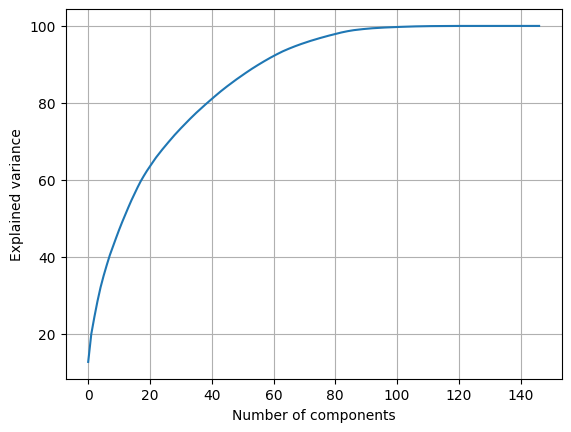

In [20]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [21]:
pca_70 = PCA(n_components = 70)
pca_70.fit(X_train)

PCA(n_components=70)

In [22]:
train_features_reduced = pca_70.transform(X_train)
val_features_reduced = pca_70.transform(X_val)
test_features_reduced = pca_70.transform(X_test)

# verify shape after PCA
print("Train features shape:", train_features_reduced.shape)
print("Val features shape:", val_features_reduced.shape)
print("Test features shape: ", test_features_reduced.shape)

# get exact variability retained
print("\nVar retained (%):", 
      np.sum(pca_70.explained_variance_ratio_ * 100))

Train features shape: (29800, 70)
Val features shape: (29751, 70)
Test features shape:  (26343, 70)

Var retained (%): 95.30027475594382


In [23]:
# convert labels to a one-hot vector
# from tensorflow.keras.utils import to_categorical

# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

# define network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Accuracy, Recall




In [24]:

MLP = Sequential()
MLP.add(InputLayer(input_shape=(70, ))) # input layer
MLP.add(Dense(64, activation='relu')) # hidden layer 2
MLP.add(Dense(32, activation='relu')) # hidden layer 2
MLP.add(Dense(1, activation='sigmoid')) # output layer

In [25]:
# optimization
MLP.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=[Precision()])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
# train (fit)

es = EarlyStopping(patience=5, restore_best_weights=True)

history = MLP.fit(train_features_reduced, y_train, 
                  epochs=20, batch_size=128, verbose=1,
                  validation_data=(val_features_reduced, y_val), callbacks = es, shuffle = True)

Epoch 1/20
233/233 [==============================] - 0s 1ms/step - loss: 0.4094 - precision: 0.1429 - val_loss: 0.3810 - val_precision: 0.0000e+00
Epoch 2/20
233/233 [==============================] - 0s 782us/step - loss: 0.3790 - precision: 0.0000e+00 - val_loss: 0.3797 - val_precision: 0.0000e+00
Epoch 3/20
233/233 [==============================] - 0s 790us/step - loss: 0.3768 - precision: 0.0000e+00 - val_loss: 0.3783 - val_precision: 0.0000e+00
Epoch 4/20
233/233 [==============================] - 0s 817us/step - loss: 0.3750 - precision: 0.0000e+00 - val_loss: 0.3786 - val_precision: 1.0000
Epoch 5/20
233/233 [==============================] - 0s 811us/step - loss: 0.3734 - precision: 0.7143 - val_loss: 0.3780 - val_precision: 0.7500
Epoch 6/20
233/233 [==============================] - 0s 800us/step - loss: 0.3720 - precision: 0.7600 - val_loss: 0.3782 - val_precision: 0.5909
Epoch 7/20
233/233 [==============================] - 0s 792us/step - loss: 0.3703 - precision: 0.7045

In [27]:
# evaluate performance on test data
test_loss, test_acc = MLP.evaluate(test_features_reduced, y_test,
                                         batch_size=128,
                                         verbose=1)
print("Test loss:", test_loss)
print("Test precision:", test_acc)

206/206 [==============================] - 0s 317us/step - loss: 0.3817 - precision: 0.4706
Test loss: 0.381747305393219
Test precision: 0.47058823704719543


In [28]:
y_pred = MLP.predict(test_features_reduced)

824/824 [==============================] - 0s 228us/step


In [29]:
y_pred

array([[0.1063215 ],
       [0.10351009],
       [0.15598978],
       ...,
       [0.09371916],
       [0.07705024],
       [0.08745757]], dtype=float32)

<Axes: ylabel='Count'>

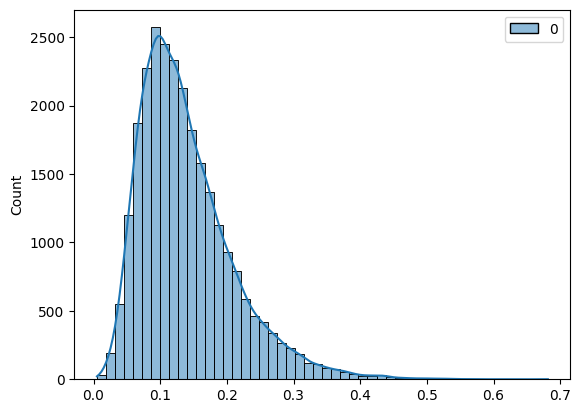

In [30]:
import seaborn as sns
sns.histplot(y_pred, bins = 50, kde=True)

In [31]:
y_pred

array([[0.1063215 ],
       [0.10351009],
       [0.15598978],
       ...,
       [0.09371916],
       [0.07705024],
       [0.08745757]], dtype=float32)

In [32]:
backtest_test['model_preds'] = y_pred

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/1787826085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_preds'] = y_pred


In [33]:
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/689424641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']


In [34]:
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/4042348346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']


In [35]:
backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/1950861892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']


In [36]:
backtest_test

f_ko            f_id              id         f_horse  \
59551 2022-10-24 19:30:00  16666362000012  16666362000225        Rain Cap   
59552 2022-10-24 19:30:00  16666362000012  16666362000049    Bronze River   
59553 2022-10-24 19:30:00  16666362000012  16666362000016         Aquamas   
59554 2022-10-24 19:30:00  16666362000012  16666362000124  Highland Queen   
59555 2022-10-24 19:30:00  16666362000012  16666362000044   Bobby Joe Leg   
...                   ...             ...             ...             ...   
85889 2023-08-20 18:45:00  16925535000012  16925535000107     Dark Island   
85890 2023-08-20 18:45:00  16925535000012  16925535000404          Traila   
85891 2023-08-20 18:45:00  16925535000012  16925535000015   Alpine Stroll   
85892 2023-08-20 18:45:00  16925535000012  16925535000353   Saratoga Gold   
85893 2023-08-20 18:45:00  16925535000012  16925535000117     Diamond Bay   

       f_pm_01m  f_pm_01m_p_back  model_preds  odds_preds  model_edge_basic  \
59551      11.0            -1.00     0.106321    0.090909          0.015412   
59552       6.4            -1.00     0.103510    0.156250         -0.052740   
59553       7.4            -1.00     0.155990    0.135135          0.020855   
59554      14.0            -1.00     0.073659    0.071429          0.002230   
59555      15.5            13.77     0.041562    0.064516         -0.022954   
...         ...              ...          ...         ...               ...   
85889       6.8            -1.00     0.104731    0.147059         -0.042328   
85890      13.0            11.40     0.095796    0.076923          0.018873   
85891      10.5            -1.00     0.093719    0.095238         -0.001519   
85892      17.5            -1.00     0.077050    0.057143          0.019907   
85893      11.5            -1.00     0.087458    0.086957          0.000501   

       model_edge_proportionate  
59551                  1.169536  
59552                  0.662465  
59553                  1.154324  
59554                  1.031223  
59555                  0.644215  
...                         ...  
85889                  0.712173  
85890                  1.245354  
85891                  0.984051  
85892                  1.348379  
85893                  1.005762  

[26343 rows x 10 columns]

In [37]:
backtest_test = backtest_test.drop(columns=['f_ko'])

In [42]:
pd.set_option('display.max_rows', None)

In [44]:
model_preds_race = backtest_test.groupby('f_id').sum().reset_index()

In [45]:
model_preds_race

f_id               id  \
0     16666362000012   99998172000628   
1     16666380000022  149997420001649   
2     16667034000015  133336272001777   
3     16667055000000  100002330001172   
4     16667076000027  100002456001184   
5     16667097000026  100002582000838   
6     16667118000011  116669826001078   
7     16667136000016  100002816000916   
8     16667154000030  116670078001652   
9     16667226000001  133337808001646   
10    16667244000022  116670708000874   
11    16667262000009   83336310000780   
12    16667877000028   83339385001112   
13    16667898000022  116675286001241   
14    16667901000007   83339505001290   
15    16667919000011  100007514001617   
16    16667940000029   66671760000825   
17    16667943000025  150011487002085   
18    16667964000001  133343712001537   
19    16667985000012   66671940000897   
20    16668054000015  116676378001012   
21    16668072000031  116676504001531   
22    16668090000019   83340450001046   
23    16668108000014  133344864002200   
24    16668126000013  116676882001872   
25    16668744000005  116681208001145   
26    16668849000001  133350792001615   
27    16668867000023  116682069001664   
28    16668900000009  116682300001701   
29    16668918000012  133351344001473   
30    16668936000024  100013616001292   
31    16668954000011  116682678001295   
32    16668972000008  150020748001672   
33    16669665000020  100017990001282   
34    16669686000010  133357488001665   
35    16669707000017  150027363001973   
36    16669716000018   66678864000680   
37    16669728000012  150027552001665   
38    16669746000001  116688222001453   
39    16669755000016  133358040001376   
40    16669764000002  166697640002178   
41    16669800000015  133358400001601   
42    16669809000003  133358472001193   
43    16669818000005  133358544001709   
44    16669827000029  133358616001771   
45    16669836000021  150028524002558   
46    16669845000023  150028605002472   
47    16669854000006   83349270000400   
48    16670533800038  150034804202841   
49    16670596800005  150035371201422   
50    16670610000011  133364880001710   
51    16670628000020  150035652002084   
52    16670664000023  116694648001682   
53    16670682000039  150036138002344   
54    16670718000008  133365744001806   
55    16672218000038  166722180003085   
56    16672224000019  133377792001616   
57    16672243200013  116705702401262   
58    16672278000017  183395058003643   
59    16672285800018  150050572202725   
60    16672299000037  133378392002459   
61    16672320000006  150050880001715   
62    16672332000003  150050988001706   
63    16672341000001  150051069002806   
64    16672347000012  116706429002155   
65    16672368000039   83361840001537   
66    16672374000026  150051366001883   
67    16672392000020  133379136001914   
68    16672410000024  150051690002969   
69    16672428000014  116706996002130   
70    16672446000031   50017338000968   
71    16672464000029  133379712001621   
72    16673130000008  100038780000896   
73    16673145000005  166731450002087   
74    16673187000014  166731870001599   
75    16673190000006  133385520001044   
76    16673202000030   50019606000539   
77    16673220000011  133385760001105   
78    16673238000015  116712666001145   
79    16673265000003  116712855000990   
80    16673283000016  116712981001095   
81    16673301000025  116713107001498   
82    16673319000018  116713233001214   
83    16673994000015  116717958001755   
84    16674048000023  116718336001101   
85    16674066000008  116718462001203   
86    16674087000029  116718609002286   
87    16674108000004  133392864000666   
88    16674138000022  116718966001935   
89    16674156000000  150067404002176   
90    16674174000003  100045044001009   
91    16674192000001  116719344002030   
92    16674912000032  166749120001690   
93    16674948000001   83374740001049   
94    16674966000003  116724762001473   
95    16674984000009  133399872001511   
96    16675002000015  100050012000827  

In [53]:
model_preds_race2 = model_preds_race[['f_id', 'model_preds', 'odds_preds']]

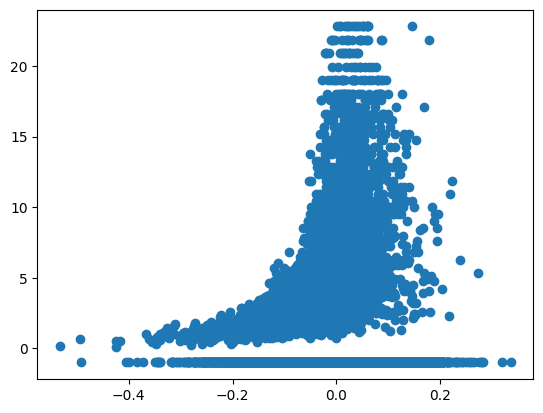

In [38]:
plt.scatter(backtest_test['model_edge_basic'], backtest_test['f_pm_01m_p_back'])

In [39]:
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[backtest_test['model_edge_basic'] >= 0]
above5 = backtest_test[backtest_test['model_edge_basic'] >= 0.05]
above10 = backtest_test[backtest_test['model_edge_basic'] >= 0.1]
above15 = backtest_test[backtest_test['model_edge_basic'] >= 0.15]
above20 = backtest_test[backtest_test['model_edge_basic'] >= 0.20]
above30 = backtest_test[backtest_test['model_edge_basic'] >= 0.30]

In [40]:
# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['f_pm_01m_p_back'].cumsum()

df0 = above0
df0['cumulative_profit'] = df0['f_pm_01m_p_back'].cumsum()

df5 = above5
df5['cumulative_profit'] = df5['f_pm_01m_p_back'].cumsum()

df10 = above10
df10['cumulative_profit'] = df10['f_pm_01m_p_back'].cumsum()

df15 = above15
df15['cumulative_profit'] = df15['f_pm_01m_p_back'].cumsum()

df20 = above20
df20['cumulative_profit'] = df20['f_pm_01m_p_back'].cumsum()

df30 = above30
df30['cumulative_profit'] = df30['f_pm_01m_p_back'].cumsum()




/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/3685990717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['cumulative_profit'] = df0['f_pm_01m_p_back'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/3685990717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['cumulative_profit'] = df5['f_pm_01m_p_back'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/3685990717.py:13: SettingWithCopyWarning: 
A value is trying to be set o

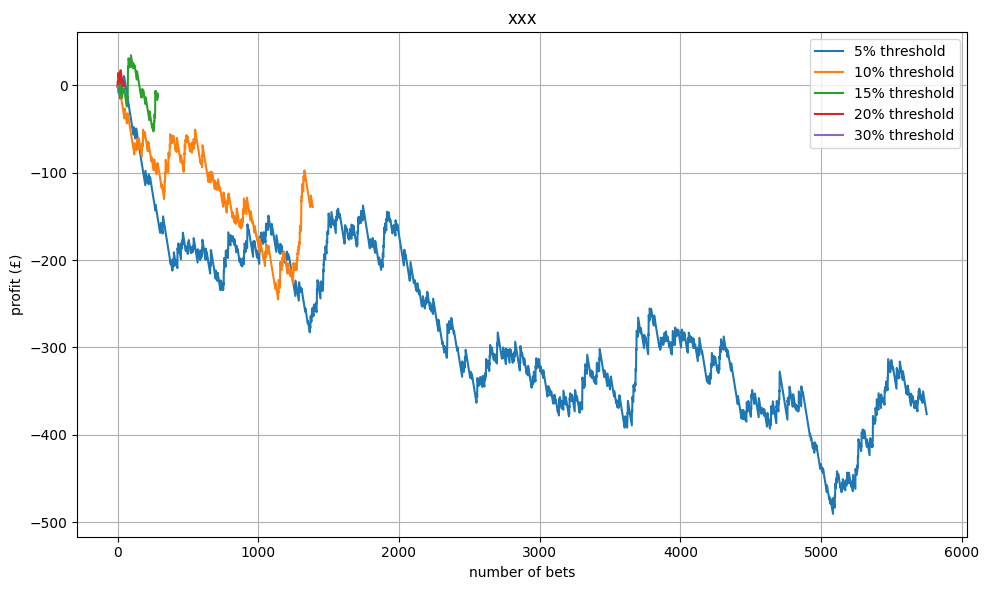

In [41]:
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
#plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='0% threshold')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='5% threshold')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='10% threshold')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='15% threshold')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='20% threshold')
plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='30% threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("df5")
print(int(df5['f_pm_01m_p_back'].count())), print(int(df5['f_pm_01m_p_back'].sum())), print(int(df5['f_pm_01m_p_back'].sum())/(int(df5['f_pm_01m_p_back'].count())))
print("------")
print("df10")
print(int(df10['f_pm_01m_p_back'].count())), print(int(df10['f_pm_01m_p_back'].sum())), print(int(df10['f_pm_01m_p_back'].sum())/(int(df10['f_pm_01m_p_back'].count())))
print("------")
print("df15")
print(int(df15['f_pm_01m_p_back'].count())), print(int(df15['f_pm_01m_p_back'].sum())), print(int(df15['f_pm_01m_p_back'].sum())/(int(df15['f_pm_01m_p_back'].count())))
print("------")
print("df20")
print(int(df20['f_pm_01m_p_back'].count())), print(int(df20['f_pm_01m_p_back'].sum())), print(int(df20['f_pm_01m_p_back'].sum())/(int(df20['f_pm_01m_p_back'].count())))
print("------")
print("df30")
print(int(df30['f_pm_01m_p_back'].count())), print(int(df30['f_pm_01m_p_back'].sum())), print(int(df30['f_pm_01m_p_back'].sum())/(int(df30['f_pm_01m_p_back'].count())))
print("------")

df5
4444
-187
-0.04207920792079208
------
df10
1847
-35
-0.018949648077964266
------
df15
901
-54
-0.05993340732519423
------
df20
437
-58
-0.13272311212814644
------
df30
99
3
0.030303030303030304
------

In [ ]:
# Create dataframes of horses above specific proba_difference thresholds

all_betsb = backtest_test
above0b = backtest_test[backtest_test['model_edge_proportionate'] >= 1]
above5b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.2]
above10b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.4]
above15b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.6]
above20b = backtest_test[backtest_test['model_edge_proportionate'] >= 1.8]
above30b = backtest_test[backtest_test['model_edge_proportionate'] >= 2]

In [ ]:
# Calculate evolutions of profits for each threshold

dfallb = all_betsb.sort_values(by='f_ko')
dfallb['cumulative_profit'] = dfallb['f_pm_01m_p_back'].cumsum()

df0b = above0b.sort_values(by='f_ko')
df0b['cumulative_profit'] = df0b['f_pm_01m_p_back'].cumsum()

df5b = above5b.sort_values(by='f_ko')
df5b['cumulative_profit'] = df5b['f_pm_01m_p_back'].cumsum()

df10b = above10b.sort_values(by='f_ko')
df10b['cumulative_profit'] = df10b['f_pm_01m_p_back'].cumsum()

df15b = above15b.sort_values(by='f_ko')
df15b['cumulative_profit'] = df15b['f_pm_01m_p_back'].cumsum()

df20b = above20b.sort_values(by='f_ko')
df20b['cumulative_profit'] = df20b['f_pm_01m_p_back'].cumsum()

df30b = above30b.sort_values(by='f_ko')
df30b['cumulative_profit'] = df30b['f_pm_01m_p_back'].cumsum()

In [ ]:
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
#plt.plot(range(1, len(df0b) + 1), df0b['cumulative_profit'], label='1 threshold')
plt.plot(range(1, len(df5b) + 1), df5b['cumulative_profit'], label='1.2 threshold')
plt.plot(range(1, len(df10b) + 1), df10b['cumulative_profit'], label='1.4 threshold')
plt.plot(range(1, len(df15b) + 1), df15b['cumulative_profit'], label='1.6 threshold')
plt.plot(range(1, len(df20b) + 1), df20b['cumulative_profit'], label='1.8 threshold')
plt.plot(range(1, len(df30b) + 1), df30b['cumulative_profit'], label='2 threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
MLP2 = Sequential()
MLP2.add(InputLayer(input_shape=(80, ))) # input layer
MLP2.add(Dense(64, activation='relu')) # hidden layer 2
MLP2.add(Dense(32, activation='relu')) # hidden layer 2
MLP2.add(Dense(1, activation='sigmoid')) # output layer

# optimization
MLP2.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=[Precision()])

MLP2.load_weights('0831-v1')

In [ ]:
# evaluate performance on test data
test_loss, test_acc = MLP2.evaluate(test_features_reduced, y_test,
                                         batch_size=128,
                                         verbose=1)
print("Test loss:", test_loss)
print("Test precision:", test_acc)

In [ ]:
backtest_test[['model_preds','odds_preds']]

In [54]:
model_preds_race2

f_id  model_preds  odds_preds
0     16666362000012     0.523344    0.578845
1     16666380000022     1.070950    0.902478
2     16667034000015     1.099606    0.921657
3     16667055000000     1.175536    0.968089
4     16667076000027     1.238164    0.968173
5     16667097000026     0.976655    0.913984
6     16667118000011     1.036991    0.964915
7     16667136000016     0.819369    0.921608
8     16667154000030     1.062187    0.949366
9     16667226000001     1.101737    0.930542
10    16667244000022     0.955787    0.944262
11    16667262000009     0.943419    0.917985
12    16667877000028     0.855610    0.912602
13    16667898000022     0.935861    0.882599
14    16667901000007     0.477810    0.631494
15    16667919000011     0.771856    0.978240
16    16667940000029     0.794816    0.902258
17    16667943000025     0.614591    0.704665
18    16667964000001     0.470212    0.687453
19    16667985000012     0.253466    0.471184
20    16668054000015     0.958797    0.954596
21    16668072000031     0.958397    0.967668
22    16668090000019     0.972166    1.005972
23    16668108000014     0.902978    0.912524
24    16668126000013     0.882706    0.936757
25    16668744000005     0.926396    0.993026
26    16668849000001     0.879260    0.933512
27    16668867000023     0.903435    0.974790
28    16668900000009     0.857083    0.902951
29    16668918000012     1.131209    0.965008
30    16668936000024     1.149679    0.775086
31    16668954000011     0.755355    0.857074
32    16668972000008     1.140449    0.989392
33    16669665000020     0.891907    0.967865
34    16669686000010     0.895052    0.935305
35    16669707000017     1.158180    0.987189
36    16669716000018     0.499112    0.896589
37    16669728000012     1.039380    0.883412
38    16669746000001     0.778615    0.826683
39    16669755000016     0.979771    0.879976
40    16669764000002     1.005373    0.926893
41    16669800000015     0.940533    0.876028
42    16669809000003     1.112980    0.964333
43    16669818000005     0.814440    0.896758
44    16669827000029     0.902682    0.849874
45    16669836000021     0.986517    0.917864
46    16669845000023     1.046710    0.928053
47    16669854000006     0.834976    0.861738
48    16670533800038     1.153869    0.978175
49    16670596800005     0.890707    0.784782
50    16670610000011     0.980988    0.962062
51    16670628000020     0.977125    0.982640
52    16670664000023     0.942874    0.916093
53    16670682000039     1.117408    0.974259
54    16670718000008     0.987607    0.975900
55    16672218000038     0.936453    0.841795
56    16672224000019     1.039163    0.989046
57    16672243200013     0.852641    0.983252
58    16672278000017     1.048723    0.891383
59    16672285800018     1.016843    0.917838
60    16672299000037     1.074924    1.003312
61    16672320000006     0.990864    0.799668
62    16672332000003     0.837787    0.940232
63    16672341000001     0.917125    0.837209
64    16672347000012     0.850410    0.909494
65    16672368000039     0.752456    0.927116
66    16672374000026     1.017251    0.946240
67    16672392000020     1.233834    0.951100
68    16672410000024     0.946758    0.978600
69    16672428000014     0.859686    0.885604
70    16672446000031     0.637014    0.864873
71    16672464000029     1.104631    0.927125
72    16673130000008     0.494425    0.786886
73    16673145000005     0.974701    0.915264
74    16673187000014     0.764458    0.867167
75    16673190000006     1.374604    0.990297
76    16673202000030     0.608248    0.999839
77    16673220000011     1.015454    0.981530
78    16673238000015     1.092411    0.961549
79    16673265000003     1.072428    0.955389
80    16673283000016     0.959570    0.874734
81    16673301000025     0.932847    0.948712
82    16673319000018     0.902362    0.980402
83    16673994000015     0.885243    0.892545
84    16674048000023     0.867528    0.883480
85    16674066000008     0.851021    0.890689
86    16674087

In [55]:
dict_odds_preds = model_preds_race2.set_index('f_id')['odds_preds'].to_dict()

In [49]:
dict_race_preds = model_preds_race2.set_index('f_id')['model_preds'].to_dict()

In [50]:
dict_race_preds

{16666362000012: 0.523343563079834,
 16666380000022: 1.0709495544433594,
 16667034000015: 1.0996061563491821,
 16667055000000: 1.1755363941192627,
 16667076000027: 1.238163948059082,
 16667097000026: 0.9766553044319153,
 16667118000011: 1.0369908809661865,
 16667136000016: 0.8193688988685608,
 16667154000030: 1.0621870756149292,
 16667226000001: 1.1017374992370605,
 16667244000022: 0.9557867050170898,
 16667262000009: 0.9434194564819336,
 16667877000028: 0.8556098341941833,
 16667898000022: 0.9358605742454529,
 16667901000007: 0.47780969738960266,
 16667919000011: 0.7718563675880432,
 16667940000029: 0.7948161363601685,
 16667943000025: 0.614591121673584,
 16667964000001: 0.4702117443084717,
 16667985000012: 0.2534656822681427,
 16668054000015: 0.9587973952293396,
 16668072000031: 0.9583972692489624,
 16668090000019: 0.9721660614013672,
 16668108000014: 0.9029775857925415,
 16668126000013: 0.882705807685852,
 16668744000005: 0.9263956546783447,
 16668849000001: 0.8792597651481628,
 166

In [51]:
backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)

In [56]:
backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)

In [57]:
backtest_test.head(20)

f_id              id            f_horse  f_pm_01m  \
59551  16666362000012  16666362000225           Rain Cap      11.0   
59552  16666362000012  16666362000049       Bronze River       6.4   
59553  16666362000012  16666362000016            Aquamas       7.4   
59554  16666362000012  16666362000124     Highland Queen      14.0   
59555  16666362000012  16666362000044      Bobby Joe Leg      15.5   
59556  16666362000012  16666362000170  Lucky Lucky Lucky      16.5   
59557  16666380000022  16666380000227     Ramon Di Loria       8.8   
59558  16666380000022  16666380000175        Majeski Man       5.8   
59559  16666380000022  16666380000237               Rory       6.6   
59560  16666380000022  16666380000200         Never Dark      10.5   
59561  16666380000022  16666380000183        Melody King       9.8   
59562  16666380000022  16666380000213       Phoenix Star      11.5   
59563  16666380000022  16666380000060     Carlton And Co      18.0   
59564  16666380000022  16666380000107       Glorious Rio      15.5   
59565  16666380000022  16666380000247    Secretinthepark      16.5   
59566  16667034000015  16667034000223        Prayer Matt       7.2   
59567  16667034000015  16667034000289       The Gloaming      11.5   
59568  16667034000015  16667034000120          Hot Scoop       6.0   
59569  16667034000015  16667034000277             Stroxx      13.5   
59570  16667034000015  16667034000096         Golden Gal      20.0   

       f_pm_01m_p_back  model_preds  odds_preds  model_edge_basic  \
59551            -1.00     0.106321    0.090909          0.015412   
59552            -1.00     0.103510    0.156250         -0.052740   
59553            -1.00     0.155990    0.135135          0.020855   
59554            -1.00     0.073659    0.071429          0.002230   
59555            13.77     0.041562    0.064516         -0.022954   
59556            -1.00     0.042301    0.060606         -0.018305   
59557            -1.00     0.211125    0.113636          0.097489   
59558            -1.00     0.144306    0.172414         -0.028108   
59559            -1.00     0.126240    0.151515         -0.025275   
59560            -1.00     0.114359    0.095238          0.019121   
59561            -1.00     0.189945    0.102041          0.087904   
59562            -1.00     0.084267    0.086957         -0.002690   
59563            -1.00     0.069238    0.055556          0.013682   
59564            -1.00     0.088689    0.064516          0.024173   
59565            -1.00     0.042781    0.060606         -0.017825   
59566            -1.00     0.236630    0.138889          0.097742   
59567            -1.00     0.136391    0.086957          0.049435   
59568            -1.00     0.181832    0.166667          0.015165   
59569            -1.00     0.153818    0.074074          0.079744   
59570            -1.00     0.118489    0.050000          0.068489   

       model_edge_proportionate  cumulative_profit  race_model_preds  \
59551                  1.169536              -1.00          0.523344   
59552                  0.662465              -2.00          0.523344   
59553                  1.154324              -3.00          0.523344   
59554                  1.031223              -4.00          0.523344   
59555                  0.644215               9.77          0.523344   
59556                  0.697969               8.77          0.523344   
59557                  1.857902               7.77          1.070950   
59558                  0.836975               6.77          1.070950   
59559                  0.833186               5.77          1.070950   
59560                  1.200770               4.77          1.070950   
59561                  1.861459               3.77          1.070950   
59562                  0.969065               2.77          1.070950   
59563                  1.246276               1.77          1.070950   
59564                  1.374681               0.77          1.070950   
59565           

In [59]:
backtest_test['model_preds_scaled'] = (backtest_test['model_preds'] / backtest_test['race_model_preds']) * backtest_test['race_odds_preds']

In [62]:
backtest_test['model_edge_basic_scaled'] = backtest_test['model_preds_scaled'] - backtest_test['odds_preds']

In [64]:
backtest_test['model_edge_prop_scaled'] = backtest_test['model_preds_scaled'] / backtest_test['odds_preds']

In [65]:
backtest_test.head(20)

f_id              id            f_horse  f_pm_01m  \
59551  16666362000012  16666362000225           Rain Cap      11.0   
59552  16666362000012  16666362000049       Bronze River       6.4   
59553  16666362000012  16666362000016            Aquamas       7.4   
59554  16666362000012  16666362000124     Highland Queen      14.0   
59555  16666362000012  16666362000044      Bobby Joe Leg      15.5   
59556  16666362000012  16666362000170  Lucky Lucky Lucky      16.5   
59557  16666380000022  16666380000227     Ramon Di Loria       8.8   
59558  16666380000022  16666380000175        Majeski Man       5.8   
59559  16666380000022  16666380000237               Rory       6.6   
59560  16666380000022  16666380000200         Never Dark      10.5   
59561  16666380000022  16666380000183        Melody King       9.8   
59562  16666380000022  16666380000213       Phoenix Star      11.5   
59563  16666380000022  16666380000060     Carlton And Co      18.0   
59564  16666380000022  16666380000107       Glorious Rio      15.5   
59565  16666380000022  16666380000247    Secretinthepark      16.5   
59566  16667034000015  16667034000223        Prayer Matt       7.2   
59567  16667034000015  16667034000289       The Gloaming      11.5   
59568  16667034000015  16667034000120          Hot Scoop       6.0   
59569  16667034000015  16667034000277             Stroxx      13.5   
59570  16667034000015  16667034000096         Golden Gal      20.0   

       f_pm_01m_p_back  model_preds  odds_preds  model_edge_basic  \
59551            -1.00     0.106321    0.090909          0.015412   
59552            -1.00     0.103510    0.156250         -0.052740   
59553            -1.00     0.155990    0.135135          0.020855   
59554            -1.00     0.073659    0.071429          0.002230   
59555            13.77     0.041562    0.064516         -0.022954   
59556            -1.00     0.042301    0.060606         -0.018305   
59557            -1.00     0.211125    0.113636          0.097489   
59558            -1.00     0.144306    0.172414         -0.028108   
59559            -1.00     0.126240    0.151515         -0.025275   
59560            -1.00     0.114359    0.095238          0.019121   
59561            -1.00     0.189945    0.102041          0.087904   
59562            -1.00     0.084267    0.086957         -0.002690   
59563            -1.00     0.069238    0.055556          0.013682   
59564            -1.00     0.088689    0.064516          0.024173   
59565            -1.00     0.042781    0.060606         -0.017825   
59566            -1.00     0.236630    0.138889          0.097742   
59567            -1.00     0.136391    0.086957          0.049435   
59568            -1.00     0.181832    0.166667          0.015165   
59569            -1.00     0.153818    0.074074          0.079744   
59570            -1.00     0.118489    0.050000          0.068489   

       model_edge_proportionate  cumulative_profit  race_model_preds  \
59551                  1.169536              -1.00          0.523344   
59552                  0.662465              -2.00          0.523344   
59553                  1.154324              -3.00          0.523344   
59554                  1.031223              -4.00          0.523344   
59555                  0.644215               9.77          0.523344   
59556                  0.697969               8.77          0.523344   
59557                  1.857902               7.77          1.070950   
59558                  0.836975               6.77          1.070950   
59559                  0.833186               5.77          1.070950   
59560                  1.200770               4.77          1.070950   
59561                  1.861459               3.77          1.070950   
59562                  0.969065               2.77          1.070950   
59563                  1.246276               1.77          1.070950   
59564                  1.374681               0.77          1.070950   
59565           

In [66]:
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0]
above5 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.05]
above10 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.1]
above15 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.15]
above20 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.20]
above30 = backtest_test[backtest_test['model_edge_basic_scaled'] >= 0.30]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['f_pm_01m_p_back'].cumsum()

df0 = above0
df0['cumulative_profit'] = df0['f_pm_01m_p_back'].cumsum()

df5 = above5
df5['cumulative_profit'] = df5['f_pm_01m_p_back'].cumsum()

df10 = above10
df10['cumulative_profit'] = df10['f_pm_01m_p_back'].cumsum()

df15 = above15
df15['cumulative_profit'] = df15['f_pm_01m_p_back'].cumsum()

df20 = above20
df20['cumulative_profit'] = df20['f_pm_01m_p_back'].cumsum()

df30 = above30
df30['cumulative_profit'] = df30['f_pm_01m_p_back'].cumsum()

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/27075034.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['cumulative_profit'] = df0['f_pm_01m_p_back'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/27075034.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['cumulative_profit'] = df5['f_pm_01m_p_back'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/27075034.py:23: SettingWithCopyWarning: 
A value is trying to be set on a c

In [77]:
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0b = backtest_test[backtest_test['model_edge_basic'] >= 0]
above5b = backtest_test[backtest_test['model_edge_basic'] >= 0.05]
above10b = backtest_test[backtest_test['model_edge_basic'] >= 0.1]
above15b = backtest_test[backtest_test['model_edge_basic'] >= 0.15]
above20b = backtest_test[backtest_test['model_edge_basic'] >= 0.20]
above30b = backtest_test[backtest_test['model_edge_basic'] >= 0.30]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['f_pm_01m_p_back'].cumsum()

df0b = above0b
df0b['cumulative_profit'] = df0b['f_pm_01m_p_back'].cumsum()

df5b = above5b
df5b['cumulative_profit'] = df5b['f_pm_01m_p_back'].cumsum()

df10b = above10b
df10b['cumulative_profit'] = df10b['f_pm_01m_p_back'].cumsum()

df15b = above15b
df15b['cumulative_profit'] = df15b['f_pm_01m_p_back'].cumsum()

df20b = above20b
df20b['cumulative_profit'] = df20b['f_pm_01m_p_back'].cumsum()

df30b = above30b
df30b['cumulative_profit'] = df30b['f_pm_01m_p_back'].cumsum()

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/2401637430.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0b['cumulative_profit'] = df0b['f_pm_01m_p_back'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/2401637430.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5b['cumulative_profit'] = df5b['f_pm_01m_p_back'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_22442/2401637430.py:23: SettingWithCopyWarning: 
A value is trying to be 

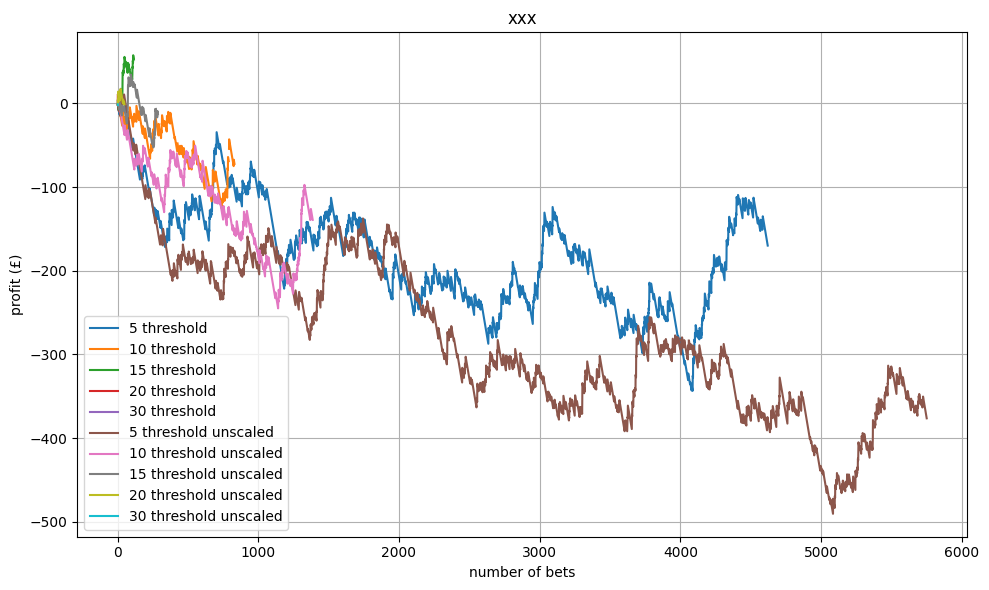

In [82]:
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
#plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='0 threshold')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='5 threshold')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='10 threshold')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='15 threshold')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='20 threshold')
plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='30 threshold')
plt.plot(range(1, len(df5b) + 1), df5b['cumulative_profit'], label='5 threshold unscaled')
plt.plot(range(1, len(df10b) + 1), df10b['cumulative_profit'], label='10 threshold unscaled')
plt.plot(range(1, len(df15b) + 1), df15b['cumulative_profit'], label='15 threshold unscaled')
plt.plot(range(1, len(df20b) + 1), df20b['cumulative_profit'], label='20 threshold unscaled')
plt.plot(range(1, len(df30b) + 1), df30b['cumulative_profit'], label='30 threshold unscaled')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()